<a href="https://colab.research.google.com/github/justinf34/SENG550-Project/blob/main/CreatingModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up Colab

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('drive/MyDrive/Colab Notebooks/SENG550/dataset/') # Chaging to dataset dir
print(os.listdir())

In [4]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 62kB/s 
     |████████████████████████████████| 204kB 45.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=7617809284b7ec2e58e9018cff3aaa7b69ebfdcf68006f013327ec465109682c
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


# Model Creation

## String Representation

In [ ]:
# Setting up spark
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("SENG550").setMaster("local[*]")
sc = SparkContext(conf=conf)

#### Loading data

In [ ]:
midGameRDD = sc.textFile('./part-*.csv')
midGameRDD.take(1)

['1,1422,4,3,1,4,2,1,0,0,1,0,1,0,0,0,0']

## Dataframe Representation

In [5]:
# Setting up Spark context using SparkSession
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('predictor-models').master("local[*]").getOrCreate()

### Looking at the data

In [24]:

mid_df = spark.read.csv('../mid_model_features_wh2/part-*.csv', header=True, inferSchema=True)
mid_df.printSchema()

root
 |-- winner: string (nullable = true)
 |-- mid_golddiff: integer (nullable = true)
 |-- bKillCount: integer (nullable = true)
 |-- rKillCount: integer (nullable = true)
 |-- first_blood: string (nullable = true)
 |-- bTowerCount: integer (nullable = true)
 |-- rTowerCount: integer (nullable = true)
 |-- first_tower: string (nullable = true)
 |-- bInhibCount: integer (nullable = true)
 |-- rInhibCount: integer (nullable = true)
 |-- first_inhib: string (nullable = true)
 |-- bDragonCount: integer (nullable = true)
 |-- rDragonCount: integer (nullable = true)
 |-- first_dragon: string (nullable = true)
 |-- bBaronCount: integer (nullable = true)
 |-- rBaronCount: integer (nullable = true)
 |-- first_baron: string (nullable = true)



**Features:**

- `mid_goldiff`: This is be the difference between the gold in each team. Computed by Blue(1) - Red(0) gold.
- `bKillCount`: The number of kills that the Blue side has.
- `rKillCount`: The number of kills that the Red side has.
- `first_blood`: Which team got the first kills of the game.
- `bTowerCount`: The number of towers that the Blue side knocked down.
- `rTowerCount`: The number of towers that the Red side knocked down.
- `first_tower`: Which team knocked down the first tower of the game.
- `bInhibCount`: The number of inhibitors that the Blue side knocked down.
- `rInhibCount`: The number of inhibitors that the Red side knocked down.
- `first_inhib`: Which team knocked down the first inhibitor of the game.
- `bDragonCount`: The number of dragons that the Blue side has.
- `rDragonCount`: The number of dragons that the Red side has.
- `first_dragon`: Which team got the first dragon of the game.
- `bBaronCount`: The number of barons that the Blue side has.
- `rBaronCount`: The number of barons that the Red side has.
- `first_dragon`: Which team got the first baron of the game

**Label:**

- `winner`: Indicates which team won the match



Looking at the first 5 matches in our dataset

In [25]:
import pandas as pd
pd.DataFrame(mid_df.take(5), columns=mid_df.columns).transpose()

,0,1,2,3,4
winner,Blue,Red,Blue,Red,Blue
mid_golddiff,1422,1368,5293,2712,-730
bKillCount,4,5,11,5,1
rKillCount,3,3,6,5,1
first_blood,Blue,Blue,Blue,Red,Blue
bTowerCount,4,1,3,2,1
rTowerCount,2,1,0,1,3
first_tower,Blue,Read,Blue,Blue,Read
bInhibCount,0,0,0,0,0
rInhibCount,0,0,0,0,0


We then can check if we have the same amount of data for when the Blue team wins and when Red team wins.

In [26]:
mid_df.groupby('winner').count().toPandas()

,winner,count
0,Blue,4146
1,Red,3474


### Summary statistics for the *numerical* data

In [28]:
numeric_data = [t[0] for t in mid_df.dtypes if t[1] == 'int']
mid_df.select(numeric_data).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
mid_golddiff,7620,209.72086614173227,2817.02348085286,-13591,12673
bKillCount,7620,3.862992125984252,2.802155522367613,0,31
rKillCount,7620,3.744225721784777,2.825049109605663,0,20
bTowerCount,7620,1.7263779527559056,1.323631865981659,0,8
rTowerCount,7620,1.5360892388451444,1.2876729076787756,0,9
bInhibCount,7620,0.0032808398950131233,0.06573059977889233,0,3
rInhibCount,7620,0.0034120734908136482,0.07053997021908105,0,4
bDragonCount,7620,0.6570866141732283,0.7255637472953317,0,4
rDragonCount,7620,0.75748031496063,0.7647421170462376,0,5


### Correlations between the numerical features

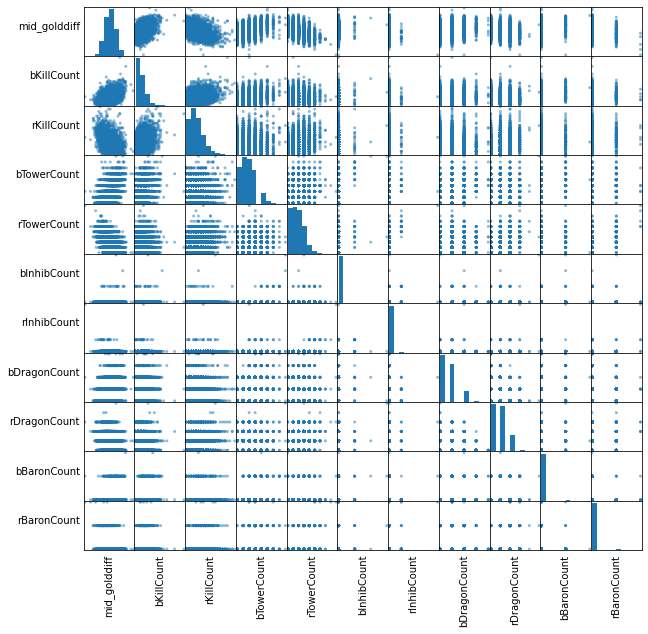

In [35]:
from pandas.plotting import scatter_matrix

numeric_features = mid_df.select(numeric_data).toPandas()
axs = scatter_matrix(numeric_features, figsize=(10,10))

n = len(numeric_features.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Probability Graphs



## Model Building

### Preparing Data

Before we can use algorithms like Logistic Regression, we must conver all our categorical features into numberic variables. Since our categorical variables are not ordinal variables, we must use the One-Hot Encoding method, which converts categories into binary vectors.

#### Defining the transfomations

In [58]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Creating coverting categorical feature to  numerical representations
categorical_features = [t[0] for t in mid_df.dtypes if t[1] == 'string' ]
stages2 = [] # Stages in our Pipeline

for col in categorical_features:
  strIndexer = StringIndexer(inputCol=col, outputCol=col + "Index")
  encoder = OneHotEncoder(inputCols=[strIndexer.getOutputCol()], outputCols=[col + "classVec"])
  stages2 += [strIndexer, encoder]

Since we doing a binary classification, our label is also categorical which we have to convert to numerical.

In [59]:
label_strIndexer = StringIndexer(inputCol="winner", outputCol="label")
stages2 += [label_strIndexer]

Now, we will combine all the features columns into a single vector column that we will call `features` which will be the input data to our models.

In [60]:
from pyspark.ml.feature import VectorAssembler

assemblerInputs = [col + "classVec" for col in categorical_features] + numeric_data
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages2 += [assembler]

Now that we have defined all our data transformations, it still has not been applied to our data. They will be applied when we start training a model. Below will be the number of transformations that our data will go through.

In [61]:
stages2

[StringIndexer_4eb21190ce74,
 OneHotEncoder_f75fd3da36b5,
 StringIndexer_cca9f49bccd4,
 OneHotEncoder_45b0a858280e,
 StringIndexer_5193cca22653,
 OneHotEncoder_7780991114f2,
 StringIndexer_cb8d20e255c1,
 OneHotEncoder_ed44a24fa29e,
 StringIndexer_8d30ecb1e8c4,
 OneHotEncoder_3c14ed96e9fd,
 StringIndexer_95159bf37fd9,
 OneHotEncoder_603688bb1419,
 StringIndexer_b1c701ea0e1f,
 VectorAssembler_a91685864b36]

In [62]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages2)
pipelineModel = pipeline.fit(mid_df)
transformed_data = pipelineModel.transform(mid_df)

#### Looking at the transformed data

In [66]:
selectedCols = ['label', 'features'] + mid_df.columns
model_df = transformed_data.select(selectedCols)
model_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- winner: string (nullable = true)
 |-- mid_golddiff: integer (nullable = true)
 |-- bKillCount: integer (nullable = true)
 |-- rKillCount: integer (nullable = true)
 |-- first_blood: string (nullable = true)
 |-- bTowerCount: integer (nullable = true)
 |-- rTowerCount: integer (nullable = true)
 |-- first_tower: string (nullable = true)
 |-- bInhibCount: integer (nullable = true)
 |-- rInhibCount: integer (nullable = true)
 |-- first_inhib: string (nullable = true)
 |-- bDragonCount: integer (nullable = true)
 |-- rDragonCount: integer (nullable = true)
 |-- first_dragon: string (nullable = true)
 |-- bBaronCount: integer (nullable = true)
 |-- rBaronCount: integer (nullable = true)
 |-- first_baron: string (nullable = true)



In [67]:
pd.DataFrame(model_df.take(5), columns=model_df.columns).transpose()

,0,1,2,3,4
label,0,1,0,1,0
features,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
winner,Blue,Red,Blue,Red,Blue
mid_golddiff,1422,1368,5293,2712,-730
bKillCount,4,5,11,5,1
rKillCount,3,3,6,5,1
first_blood,Blue,Blue,Blue,Red,Blue
bTowerCount,4,1,3,2,1
rTowerCount,2,1,0,1,3
first_tower,Blue,Read,Blue,Blue,Read


From the dataframe above, we can see that 0 indicates for Blue and 1 indicates for Red.

#### Splitting the data into train and test sets

In [68]:
weights = [.8, .2] # train/test split
seed = 42
trainData, testData = model_df.randomSplit(weights,seed)
print("Training Dataset Count: " + str(trainData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 6166
Test Dataset Count: 1454


### Model 1 - Logistic Regression

Now we will build our first model which use the logistic regression algorithm. This will be used as our baseline model as we explore other alogrithms and change the features we give our model.

In [81]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)

# Train model with Training Data
lrModel = lr.fit(trainData)

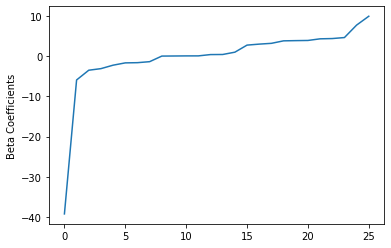

In [82]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

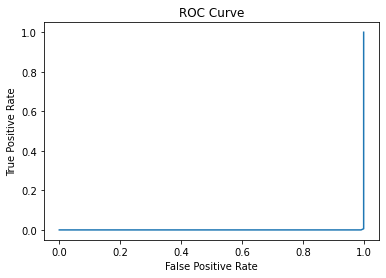

In [88]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['TPR'],roc['FPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaAboveROC))

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [90]:
predictions = lrModel.transform(testData)
predCols = ['mid_golddiff', 'bKillCount', 'rKillCount', 'first_blood',\
            'bTowerCount', 'rTowerCount', 'first_tower', 'bInhibCount',\
            'rInhibCount', 'first_inhib', 'bDragonCount', 'rDragonCount',\
            'first_dragon', 'bBaronCount', 'rBaronCount', 'first_baron',\
            'rawPrediction', 'prediction', 'probability']

pd.DataFrame(predictions.take(5), columns=predictions.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
winner,Blue,Blue,Blue,Blue,Blue
mid_golddiff,659,1166,2128,1625,2106
bKillCount,1,4,8,4,4
rKillCount,0,1,2,1,3
first_blood,Blue,Blue,Blue,Blue,Blue
bTowerCount,0,0,0,1,1
rTowerCount,0,0,0,0,0
first_tower,Blue,Blue,Blue,Blue,Blue


In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0
